In [64]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import KFold, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LassoCV

from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.utils import concordance_index

from sksurv.ensemble import RandomSurvivalForest
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.metrics import concordance_index_censored, cumulative_dynamic_auc
from sksurv.util import Surv
from sklearn.feature_selection import VarianceThreshold
warnings.filterwarnings("ignore")

In [83]:
print("【加载数据】")
df_radiomics = pd.read_csv("radiomics_features.csv")
df_clinical = pd.read_csv("clinical_data.csv")
df_clinical = df_clinical[["PatientID", "Survival.time", "deadstatus.event"]]
df_merged = pd.merge(df_radiomics, df_clinical, on="PatientID")
print(f"合并后数据共 {len(df_merged)} 个样本")
print("数据预览：")
print(df_merged.head())

X = df_merged.drop(columns=['PatientID', 'Survival.time', 'deadstatus.event'])
y_time = df_merged['Survival.time']
y_event = df_merged['deadstatus.event'].astype(bool)
y = Surv.from_arrays(y_event, y_time)

【加载数据】
合并后数据共 421 个样本
数据预览：
   PatientID  original_shape_Elongation  original_shape_Flatness  \
0  LUNG1-228                   0.618878                 0.521172   
1  LUNG1-217                   0.762101                 0.568514   
2  LUNG1-025                   0.843107                 0.654909   
3  LUNG1-022                   0.787082                 0.602927   
4  LUNG1-210                   0.743971                 0.665024   

   original_shape_LeastAxisLength  original_shape_MajorAxisLength  \
0                       59.939282                      115.008657   
1                       61.967448                      108.999017   
2                       55.585017                       84.874402   
3                       53.768866                       89.179746   
4                       47.502519                       71.429830   

   original_shape_Maximum2DDiameterColumn  \
0                               86.927204   
1                              100.845735   
2            

In [84]:
# 2. 预处理：缺失值填充与标准化
imputer = SimpleImputer(strategy="mean")
scaler = StandardScaler()
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
#方差过滤
var_filter = VarianceThreshold(threshold=1e-3)
X_var = pd.DataFrame(var_filter.fit_transform(X), columns=X.columns[var_filter.get_support()])

# Lasso 拟合
lasso = LassoCV(cv=5, random_state=0).fit(X_var, y_time)
selected_features = X_var.columns[lasso.coef_ != 0]
X = X_var[selected_features]  # 注意更新的 X
print(X.shape)

(421, 33)


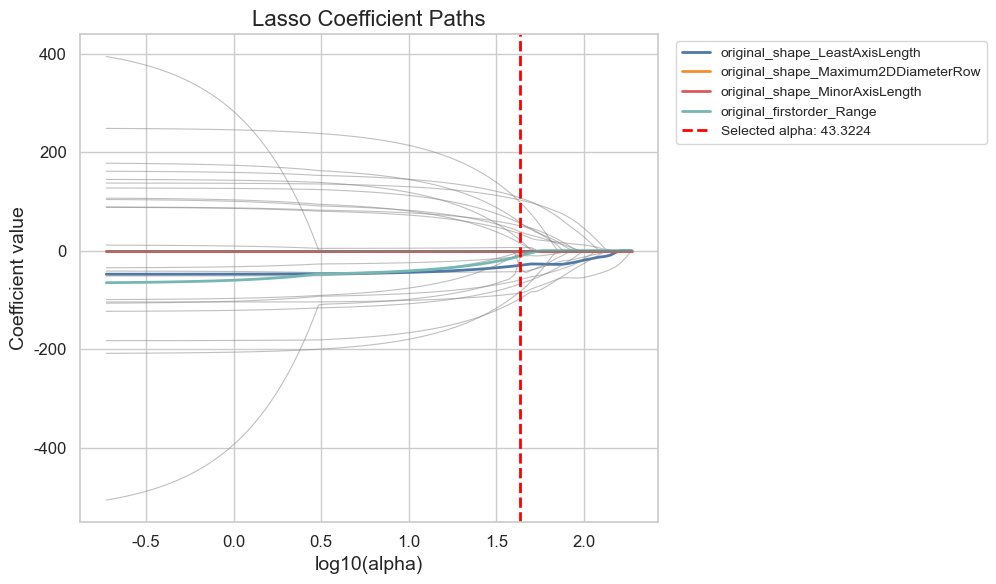

In [89]:
from sklearn.linear_model import lasso_path
import matplotlib.pyplot as plt
import numpy as np

# 计算 Lasso 路径
alphas_lasso, coefs_lasso, _ = lasso_path(X, y_time, alphas=None)

# 横坐标为 log10(alpha)
plt.figure(figsize=(12, 6))
log_alphas = np.log10(alphas_lasso)

# 只高亮最终被选中的特征，其它特征不加 label
for coef, feature in zip(coefs_lasso, X_var.columns):
    if feature in selected_features:  # 仅高亮被选中特征
        plt.plot(log_alphas, coef, label=feature, linewidth=2)
    else:
        plt.plot(log_alphas, coef, color='grey', linewidth=0.8, alpha=0.5)

plt.xlabel("log10(alpha)")
plt.ylabel("Coefficient value")
plt.title("Lasso Coefficient Paths")
plt.axvline(np.log10(lasso.alpha_), color='red', linestyle='--', label=f'Selected alpha: {lasso.alpha_:.4f}')

# 设置图例排版（分多列）
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', ncol=1, fontsize='small')  # ✅ 可调节 ncol=2~3
plt.tight_layout(rect=[0, 0, 0.85, 1])  # ✅ 给右侧图例留空间
plt.savefig("lasso_coefficient_paths_compact.png", dpi=300)
plt.show()


In [90]:
# 5. 模型初始化
coxnet_model = CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01, max_iter=10000)
rsf_model = RandomSurvivalForest(n_estimators=100, min_samples_split=10, min_samples_leaf=15, n_jobs=-1, random_state=0)
gbm_model = GradientBoostingSurvivalAnalysis(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=32)

models = {
    'Coxnet': coxnet_model,
    'RSF': rsf_model,
    'GBM': gbm_model
}

results = {}
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [91]:
# 6. 交叉验证评估 C-index
for name, model in models.items():
    print(f"Training {name} model...")
    cindex_scores = []
    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        y_train_event = y_train['event']
        y_train_time = y_train['time']
        y_val_event = y_val['event']
        y_val_time = y_val['time']

        try:
            model.fit(X_train, y_train)
            pred_val = model.predict(X_val)
            c_index = concordance_index_censored(y_val_event, y_val_time, pred_val)[0]
        except Exception as e:
            print(f"{name} failed on fold due to: {e}")
            c_index = np.nan

        cindex_scores.append(c_index)
    results[name] = cindex_scores
print(results)

Training Coxnet model...
Training RSF model...
Training GBM model...
{'Coxnet': [0.6112084063047285, 0.6666666666666666, 0.5428657074340527, 0.6477239779646274, 0.6592440668033988], 'RSF': [0.5697606538237011, 0.6501912327155046, 0.6076139088729017, 0.6184401275732097, 0.6211544096103135], 'GBM': [0.5863981319322825, 0.6154751397469844, 0.5911270983213429, 0.6088721368512612, 0.6281863463228831]}


Calculating SHAP values for RSF...


PermutationExplainer explainer: 422it [43:44,  6.25s/it]                        


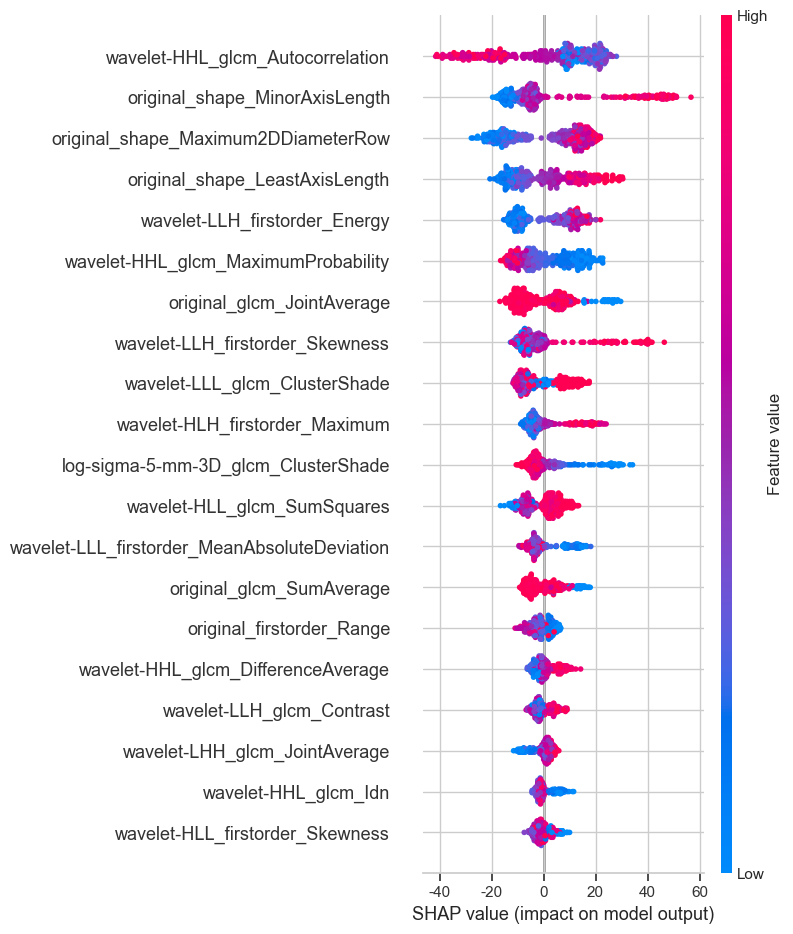

In [97]:
print("Calculating SHAP values for gbm_model...")
rsf_model.fit(X, y)
explainer = shap.Explainer(gbm_model.predict, X)
shap_values = explainer(X)
shap.summary_plot(shap_values, X, show=False)
plt.savefig("shap_summary_plot.png")

In [105]:
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt
import numpy as np
import os

# 假设你已经训练好了三个模型：coxnet_model, rsf_model, coxph_model
# 并且有数据：X, y_time, y_event

models = {
    "Coxnet": coxnet_model,
    "RSF": rsf_model,
    "GBM": gbm_model
}

# 保存图像目录
os.makedirs("km_plots", exist_ok=True)

for model_name, model in models.items():
    print(f"Processing {model_name}...")

    # 获取模型预测（可以是风险分数或预测生存时间等）
    preds = model.predict(X)

    # 用中位数划分高低风险组
    median_pred = np.median(preds)
    risk_group = preds > median_pred

    # 拟合 KM 曲线
    fig, ax = plt.subplots(figsize=(8, 6))
    kmf = KaplanMeierFitter()

    kmf.fit(y_time[risk_group], event_observed=y_event[risk_group], label='High Risk')
    kmf.plot(ax=ax)

    kmf.fit(y_time[~risk_group], event_observed=y_event[~risk_group], label='Low Risk')
    kmf.plot(ax=ax)

    # 计算 log-rank 检验的 p 值
    results = logrank_test(
        y_time[risk_group], y_time[~risk_group],
        event_observed_A=y_event[risk_group],
        event_observed_B=y_event[~risk_group]
    )
    p_value = results.p_value

    # 转换为科学计数法字符串（例如：1.23e-05）
    p_text = f"Log-rank p = {p_value:.1e}"

    # 在图的右上角写入 p 值
    plt.text(
        0.95, 0.7, p_text,
        horizontalalignment='right',
        verticalalignment='top',
        transform=ax.transAxes,
        fontsize=12,
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='grey')
    )

    # 设置图像标题和标签
    plt.title(f"{model_name} Kaplan-Meier Curve")
    plt.xlabel("Time")
    plt.ylabel("Survival Probability")
    plt.tight_layout()

    # 保存图像
    plt.savefig(f"km_plots/{model_name.lower()}_km_curve.png", dpi=300)
    plt.close()



Processing Coxnet...
Processing RSF...
Processing GBM...
